<a href="https://colab.research.google.com/github/stevenlimcorn/covid-detection/blob/main/Covid_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install timm

In [3]:
import torch
import random
import os
import numpy as np
import torch.nn as nn
import pandas as pd
import math
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sn
from torch.utils.data import DataLoader
from PIL import Image
import timm
import torchvision.transforms as transforms
import glob

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

### Data Preprocessing

In [5]:
IMG_SIZE = 224
BATCH_SIZE = 32

### Load Data

In [6]:
!rm -rf /root/.kaggle.
!mkdir /root/.kaggle 
!mv kaggle.json /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory


In [7]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

covid19-radiography-database.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
!unzip -q covid19-radiography-database.zip

replace COVID-19_Radiography_Dataset/COVID.metadata.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A
A
A


In [9]:
class CovidDataset():
    
    def __init__(self, image_paths, labels, transforms=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        file_name = self.image_paths[idx]
        image = Image.open(file_name).convert("RGB")
        
        if self.transforms is not None:
            image = self.transforms(image)
        

        return image, self.labels[idx]

In [10]:
lung_opacity = sorted(glob.glob("/content/COVID-19_Radiography_Dataset/Lung_Opacity/*.png"))
normal = sorted(glob.glob("/content/COVID-19_Radiography_Dataset/Normal/*.png"))
viral_pneumonia = sorted(glob.glob("/content/COVID-19_Radiography_Dataset/Viral Pneumonia/*.png"))
covid = sorted(glob.glob("/content/COVID-19_Radiography_Dataset/COVID/*.png"))

In [11]:
len(lung_opacity), len(normal), len(viral_pneumonia), len(covid)

(6012, 10192, 1345, 3616)

In [12]:
np.array(Image.open(lung_opacity[0]).convert("RGB")).shape

(299, 299, 3)

In [13]:
classes = [lung_opacity, normal, viral_pneumonia, covid]

In [14]:
data_df = pd.DataFrame(columns=["images", "labels"])

In [15]:
for i, data in enumerate(classes):
    data_df = data_df.append(pd.DataFrame({"images": data, "labels": [i for j in range(len(data))]}))

In [16]:
data_df

,images,labels
0,/content/COVID-19_Radiography_Dataset/Lung_Opa...,0
1,/content/COVID-19_Radiography_Dataset/Lung_Opa...,0
2,/content/COVID-19_Radiography_Dataset/Lung_Opa...,0
3,/content/COVID-19_Radiography_Dataset/Lung_Opa...,0
4,/content/COVID-19_Radiography_Dataset/Lung_Opa...,0
...,...,...
3611,/content/COVID-19_Radiography_Dataset/COVID/CO...,3
3612,/content/COVID-19_Radiography_Dataset/COVID/CO...,3
3613,/content/COVID-19_Radiography_Dataset/COVID/CO...,3
3614,/content/COVID-19_Radiography_Dataset/COVID/CO...,3


### Transforms

In [17]:
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_test = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

#### Train Validation Test

In [18]:
train_val_image, test_image, train_val_label, test_label = train_test_split(data_df.images.values, data_df.labels.values, test_size=0.1, stratify=data_df.labels.values)

In [19]:
train_image, validation_image, train_label, validation_label = train_test_split(train_val_image, train_val_label, test_size=(1/9), stratify=train_val_label)

In [20]:
len(train_image), len(validation_image), len(test_image)

(16931, 2117, 2117)

In [21]:
train_dataset = CovidDataset(train_image, train_label, transforms_train)

In [22]:
validation_dataset = CovidDataset(validation_image, validation_label, transforms_test)

In [23]:
test_dataset = CovidDataset(test_image, test_label, transforms_test)

In [24]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Training Loop

In [25]:
def train(model, train_loader, optimizer, criterion, device, scheduler=None):
    total_correct = 0.0
    total_loss = 0.0
    batch_loss = 0.0
    batch_correct = 0.0

    model.train()
    for idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        # forward
        output = model(inputs)
        # calculate loss
        loss = criterion(output, labels)
        loss.backward()
        
        correct = (output.argmax(dim=1) == labels).sum().item()
        
        total_correct += correct
        batch_correct += correct/len(labels)
        total_loss += loss.item()
        batch_loss += loss.item()
        
        optimizer.step()

        if (idx + 1) % 100 == 0:
            print(f"Batch Number {idx + 1}: Average Loss {batch_loss/100} Average Accuracy {batch_correct/100}")
            batch_correct = 0.0
            batch_loss = 0.0

        if scheduler is not None:
            scheduler.step()
    return total_correct/len(train_loader.dataset), total_loss/len(train_loader)

### Evaluation Loop

In [26]:
def evaluate(model, test_loader, criterion, device):
    total_correct = 0.0
    total_loss = 0.0
    
    model.eval()
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # forward
        output = model(inputs)
        # calculate loss
        loss = criterion(output, labels)
        total_correct += (output.argmax(dim=1) == labels).sum().item()
        total_loss += loss.item()
        
    return total_correct/len(test_loader.dataset), total_loss/len(test_loader)

### Training Preparation

In [27]:
LR = 2e-05
EPOCHS = 20

In [28]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
### number of unique classes == 4
model.head = nn.Linear(768, 4)

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


In [29]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.995)
device = "cuda"

In [30]:
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn

In [30]:
def run(model, train_loader, validation_loader, optimizer, criterion, device, scheduler=None):
    current_patience = 0
    previous_valid_loss = None
    best_valid_loss = None

    for epoch in tqdm(range(EPOCHS)):
        print("==================================================")
        print(f"EPOCH {epoch + 1}")
        train_accuracy, train_loss = train(model, train_loader, optimizer, criterion, device, scheduler=None)
        print(f"[TRAIN] EPOCH {epoch + 1} - LOSS: {train_loss}, ACCURACY: {train_accuracy}")
        validation_accuracy, validation_loss = evaluate(model, validation_loader, criterion, device)
        print(f"[VALIDATE] EPOCH {epoch + 1} - LOSS: {validation_loss}, ACCURACY: {validation_accuracy}")
        print("==================================================")

        # first iteration
        if best_valid_loss is None and previous_valid_loss is None:
            best_valid_loss = validation_loss
            torch.save(model, "/content/drive/MyDrive/covid_pneumonia_lungopacity/model.pth")
            previous_valid_loss = validation_loss
            continue
        # early stopping
        if validation_loss >= previous_valid_loss:
            current_patience += 1
            if current_patience >= 5:
                print("Early Stop")
                break
            previous_valid_loss = validation_loss

        # save best model
        if validation_loss <= best_valid_loss:
            torch.save(model, "/content/drive/MyDrive/covid_pneumonia_lungopacity/model.pth")
            best_valid_loss = validation_loss
            patience = 0

In [ ]:
run(model, train_loader, validation_loader, optimizer, criterion, device, scheduler)

EPOCH 1
Batch Number 100: Average Loss 0.6921478500962257 Average Accuracy 0.731875
Batch Number 200: Average Loss 0.45670128241181374 Average Accuracy 0.8259375
Batch Number 300: Average Loss 0.4079573652148247 Average Accuracy 0.843125
Batch Number 400: Average Loss 0.339188366830349 Average Accuracy 0.8778125
Batch Number 500: Average Loss 0.33106865726411344 Average Accuracy 0.881875
[TRAIN] EPOCH 1 - LOSS: 0.4435815490079376, ACCURACY: 0.8349181973894041
[VALIDATE] EPOCH 1 - LOSS: 0.2433501940164993, ACCURACY: 0.911195087387813
EPOCH 2
Batch Number 100: Average Loss 0.31785465583205225 Average Accuracy 0.8890625
Batch Number 200: Average Loss 0.2912125682085753 Average Accuracy 0.8971875
Batch Number 300: Average Loss 0.31557473927736285 Average Accuracy 0.885625
Batch Number 400: Average Loss 0.2776003746688366 Average Accuracy 0.898125
Batch Number 500: Average Loss 0.26833083674311636 Average Accuracy 0.9009375
[TRAIN] EPOCH 2 - LOSS: 0.29469287664682237, ACCURACY: 0.8942767704

In [31]:
model = torch.load("/content/drive/MyDrive/covid_pneumonia_lungopacity/model.pth")

In [38]:
def predict(model, test_loader, criterion, device):
    total_loss = 0.0
    preds = list()
    targets = list()
    
    model.eval()
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # forward
        output = model(inputs)
        # calculate loss
        loss = criterion(output, labels)
        preds += torch.topk(output, 1)[1].cpu().detach().numpy().tolist()
        targets += labels.cpu().detach().numpy().tolist()
        total_loss += loss.item()
        
    return total_loss/len(test_loader), preds, targets

In [39]:
test_loss, preds, targets = predict(model, test_loader, criterion, device)

In [40]:
test_loss

0.12432066815611172

In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [43]:
accuracy_score(preds, targets) * 100

95.79593764761455

In [49]:
cm = confusion_matrix(targets, preds)

In [50]:
df_cm = pd.DataFrame(cm, index = [i for i in ["lung opacity", "normal", "viral pneumonia", "covid"]], columns = [i for i in ["lung opacity", "normal", "viral pneumonia", "covid"]])

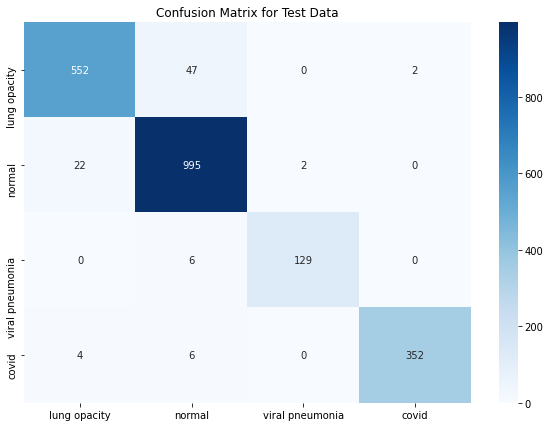

In [51]:
plt.figure(figsize = (10,7))
plt.title("Confusion Matrix for Test Data")
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')